# Applications

In our applications section, we are going to try to predict a couple things. First, we will use the residuals to create a weather-adjusted "epa over expected" metric. Then, we will try to see the best players in each circumstance. We will then compare a couple players and explain what the numbers mean.

Before we begin, let us import our packages and read in the file from the last script.

In [2]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns

In [3]:
predictions = pd.read_csv("predictions.csv")

Here are the best players in terms of weather-adjusted EPA Over Expected:

In [5]:
predictions["epaoe"] = predictions["sum_epa"] - predictions["predicted_values"]
predictions["passer_player_name"] = np.where(predictions["passer_player_name"] == "Aa.Rodgers", "A.Rodgers", predictions["passer_player_name"])

players = predictions.groupby("passer_player_name").agg(
    mean_epaoe =('epaoe', 'mean'), actual_epa = ("sum_epa", "mean"), count=('passer_player_name', 'size') 

).reset_index()

players = players.sort_values(by="mean_epaoe", ascending=False)

players = players[players["count"] > 10]
(players.head(20))

,passer_player_name,mean_epaoe,actual_epa,count
133,P.Mahomes,8.054402,8.600468,109
164,T.Romo,7.206429,8.898573,14
20,B.Purdy,6.759869,8.199790,27
155,T.Brady,5.472613,6.356368,151
7,A.Rodgers,4.783755,5.816825,125
47,D.Brees,4.173599,5.921350,92
88,J.Love,3.733722,3.831021,18
81,J.Garoppolo,3.693906,4.653359,63
56,D.Prescott,3.162725,3.476615,69
21,B.Roethlisberger,3.146628,4.238270,112


Now these are our generalized rankings. What about in rain? Wind? Cold weather? Let's find out.

## Best players in rain

In [6]:
rainy_games = predictions[predictions["is_rainy"] == 1]
players_rain = rainy_games.groupby("passer_player_name").agg(
    epaoe_rain =('epaoe', 'mean'), epa_rain = ("sum_epa", "mean"), count_rain =('passer_player_name', 'size') 

).reset_index()

players_rain = players_rain.sort_values(by="epaoe_rain", ascending=False)

players_rain = players_rain[players_rain["count_rain"] > 4]
players_rain.head(20)

,passer_player_name,epaoe_rain,epa_rain,count_rain
24,D.Brees,11.055251,13.282162,5
83,T.Brady,7.418390,6.041207,12
78,R.Tannehill,4.755206,2.791818,5
29,D.Prescott,3.058683,-0.761609,5
12,B.Roethlisberger,2.967816,0.621943,8
2,A.Rodgers,2.220144,2.288956,8
79,R.Wilson,2.208732,-0.059037,12
36,J.Allen,1.774648,-0.540475,12
19,C.Newton,1.390352,1.208961,6
3,A.Smith,1.128869,1.614912,7


## Best players in wind

In [16]:
windy_games = predictions[predictions["mean_wind"] >14]
players_wind = windy_games.groupby("passer_player_name").agg(
    epaoe_wind =('epaoe', 'mean'), epa_wind = ("sum_epa", "mean"), count_wind =('passer_player_name', 'size') 

).reset_index()

players_wind = players_wind.sort_values(by="epaoe_wind", ascending=False)

players_wind = players_wind[players_wind["count_wind"] > 4]
(players_wind.head(20))

,passer_player_name,epaoe_wind,epa_wind,count_wind
88,P.Mahomes,10.328202,8.877411,15
31,D.Brees,9.557712,14.395182,10
56,J.Goff,6.855964,5.984429,7
100,T.Brady,6.477791,7.018213,13
109,T.Tagovailoa,6.349901,3.194122,7
49,J.Burrow,5.721422,4.772493,6
72,L.Jackson,5.297998,4.003143,7
92,R.Fitzpatrick,4.553936,2.606496,13
2,A.Luck,3.650284,4.480347,5
47,J.Allen,3.581002,2.132090,15


## Best players in the cold

In [18]:
cold_games = predictions[predictions["mean_temp"] >= 32]
players_cold = cold_games.groupby("passer_player_name").agg(
    epaoe_cold =('epaoe', 'mean'), epa_cold = ("sum_epa", "mean"), count_cold =('passer_player_name', 'size') 

).reset_index()

players_cold = players_cold.sort_values(by="epaoe_cold", ascending=False)

players_cold = players_cold[players_cold["count_cold"] > 4]
(players_cold.head(20))

,passer_player_name,epaoe_cold,epa_cold,count_cold
130,P.Mahomes,7.975887,8.794205,95
161,T.Romo,7.874406,9.295937,13
19,B.Purdy,6.759869,8.199790,27
152,T.Brady,5.273582,6.174414,138
7,A.Rodgers,4.479029,5.602281,105
46,D.Brees,4.173599,5.921350,92
80,J.Garoppolo,3.761171,4.849506,62
20,B.Roethlisberger,3.277226,4.484264,105
132,P.Rivers,3.264058,4.441026,105
164,T.Tagovailoa,3.133378,3.899320,49


## Summarizing it all

Let's combine all of the above tables and see how a player's EPAOE fluctuates in the different circumstances.

In [24]:
players_agg = players.merge(players_rain, on="passer_player_name", how="left") \
                     .merge(players_wind, on="passer_player_name", how="left") \
                     .merge(players_cold, on="passer_player_name", how="left") \
                     .dropna()
players_agg = players_agg.head(10)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


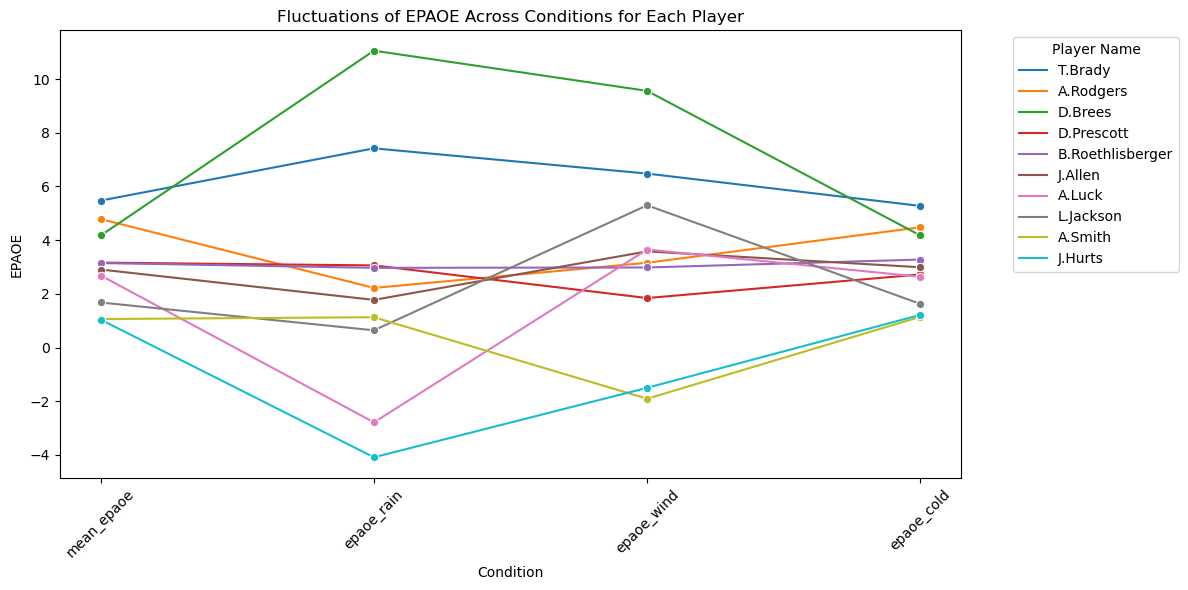

In [25]:
df_melted = players_agg.melt(
    id_vars="passer_player_name", 
    value_vars=["mean_epaoe", "epaoe_rain", "epaoe_wind", "epaoe_cold"],
    var_name="Condition", 
    value_name="EPAOE"
)

# Plot the fluctuations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x="Condition", y="EPAOE", hue="passer_player_name", marker="o")
plt.xticks(rotation=45)
plt.xlabel("Condition")
plt.ylabel("EPAOE")
plt.title("Fluctuations of EPAOE Across Conditions for Each Player")
plt.legend(title="Player Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()